<a href="https://colab.research.google.com/github/overfatih/TDDI_2024/blob/main/sentiment_analysis_turkish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import re
import nltk
import pandas as pd
import nltk as nlp
nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords
stopWords = set(stopwords.words('turkish'))
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import seaborn as sns
from sklearn.utils import class_weight
import matplotlib
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
import random
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import f1_score, classification_report
from spacy.tokenizer import Tokenizer
from spacy.lang.tr import Turkish
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ai/datasets/magaza_yorumlari_duygu_analizi.csv', encoding= 'utf-16')
df.head()

,Görüş,Durum
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",Olumsuz
1,hizli teslimat tesekkürler,Tarafsız
2,ses olayı süper....gece çalıştır sıkıntı yok.....,Olumlu
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,Olumsuz
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,Olumsuz


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11429 entries, 0 to 11428
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Görüş   11426 non-null  object
 1   Durum   11429 non-null  object
dtypes: object(2)
memory usage: 178.7+ KB


In [ ]:
## null olan veriler kaldırılıyor
df = df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11426 entries, 0 to 11428
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Görüş   11426 non-null  object
 1   Durum   11426 non-null  object
dtypes: object(2)
memory usage: 267.8+ KB


In [ ]:
df = df.rename({'Görüş': 'review'}, axis=1)
df = df.rename({'Durum': 'status'}, axis=1)

In [ ]:
df.head()

,review,status
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",Olumsuz
1,hizli teslimat tesekkürler,Tarafsız
2,ses olayı süper....gece çalıştır sıkıntı yok.....,Olumlu
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,Olumsuz
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,Olumsuz


In [ ]:
df.columns

Index(['review', 'status'], dtype='object')

In [ ]:
df["status"].value_counts()

status
Olumlu      4252
Olumsuz     4237
Tarafsız    2937
Name: count, dtype: int64

status
Olumlu      4252
Olumsuz     4237
Tarafsız    2937
Name: count, dtype: int64


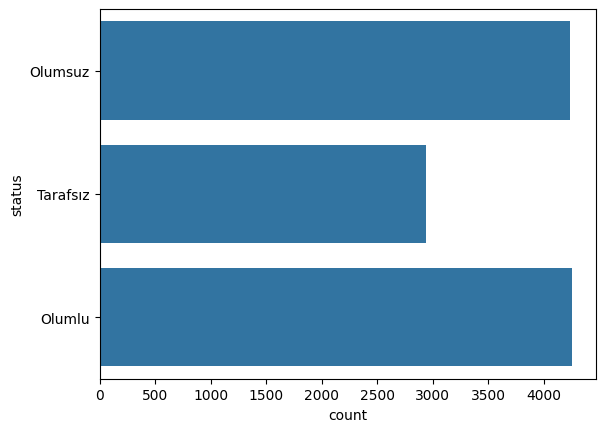

In [ ]:
sns.countplot(df["status"])
print(df.status.value_counts())

In [ ]:
df['status'] = df.loc[:, 'status'].map({'Olumlu' : 2, 'Olumsuz' : 0 , 'Tarafsız' : 1})

In [ ]:
df

,review,status
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",0
1,hizli teslimat tesekkürler,1
2,ses olayı süper....gece çalıştır sıkıntı yok.....,2
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,0
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,0
...,...,...
11424,biraz fazla ısınıyor ama sorumsuz çalışıyor,1
11425,orijinal ürün fakat ambalaj bize ulaşana kadar...,1
11426,bu cihazı 1 yıldır kullanıyorum cihazı çok beğ...,0
11427,Bir sene olmadı ayar düğmesine basıyorum ekran...,1


In [ ]:
def pre_processing(text):
    text = text.lower()  #Büyük harften -Küçük harfe çevirme
    #text = re.sub("[^abcçdefgğhıijklmnoöprsştuüvyz]"," ",text
    text = text.replace('[^\w\s]', '')
    ## sayılar silinsin
    text = text.replace('\d', '')
    text=nltk.word_tokenize(text) # splits the words that are in the sentence from each other.
    text =[word for word in text if not word in set(stopwords.words("turkish"))]
    # sentences < 500
    #if len(text) > 500:
    #  text = text[:500]
    # kelime kokunu bulma
    lemma=nlp.WordNetLemmatizer()
    text=[lemma.lemmatize(word) for word in text] # this code finds the root of the word for a word in the sentence and change them to their root form.
    text=" ".join(text)
    return text

In [ ]:
df["review"]=df["review"].apply(lambda x: pre_processing(x))

In [ ]:
#device = 'cuda'

In [ ]:
def filter(text):
  final_text = ''
  for word in text.split():
    if word.startswith('@'):
      continue
    elif word[:-3] in ['com', 'org']:
      continue
    elif word.startswith('pic') or word.startswith('http') or word.startswith('www'):
      continue
    else:
      final_text += word + ' '
  return final_text

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-128k-uncased")
bert = AutoModel.from_pretrained("dbmdz/bert-base-turkish-128k-uncased")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/740M [00:00<?, ?B/s]

In [ ]:
def feature_extraction(text):
  tokens = tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
  input_ids = tokens['input_ids']
  attention_mask = tokens['attention_mask']
  x = tokenizer.encode(filter(text))
  with torch.no_grad():
    outputs = bert(input_ids, attention_mask=attention_mask)
  x = outputs.last_hidden_state
  return list(x[0][0].cpu().numpy())

In [ ]:
## train test split
from sklearn.model_selection import train_test_split, cross_val_score

train_set, test_set = train_test_split(df,random_state=42,test_size=0.2)
print(train_set.shape, test_set.shape)

(9140, 2) (2286, 2)


In [ ]:
train_set.head()

,review,status
3054,ürünün parçalama gücü iyi.çift bıçak olunca iy...,2
2249,ürünü bir seneyi geçiktir kullanıyorum bi yanl...,2
6115,tek avantaji toz torbasi olmamasi.gereksiz güç...,0
7742,👍👍👍,2
6108,"bekledigim çıkmadı , sıvı",0


In [ ]:
print(train_set['review'][3485])

kargo hızlı şekilde elime ulaştı çayı sıcak tutma ayarı sayesinde suyu sogutmuyor kesinlikle tavsiye ederim


In [ ]:
#mapping = {'negative':0, 'neutral':1, 'positive':2}

X_test = []
y_test = []

for element in tqdm(test_set.index):
    X_test.append(feature_extraction(test_set['review'][element]))
    y_test.append(test_set['status'][element])

100%|██████████| 2286/2286 [1:08:44<00:00,  1.80s/it]


In [ ]:
X_train = []
y_train = []
for element in tqdm(train_set.index):
    X_train.append(feature_extraction(train_set['review'][element]))
    y_train.append(train_set['status'][element])

 41%|████      | 3718/9140 [1:51:44<2:25:38,  1.61s/it]

In [ ]:
print(X_test[0])

['l']


In [ ]:
x = X_train
y = y_train
plt.scatter(x, y,alpha=0.5)
plt.show()

NameError: name 'X_train' is not defined

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, activation='tanh', solver='adam', alpha=1e-5, learning_rate='constant',
                      verbose=1, early_stopping=True)
model.fit(X_train, y_train)
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))

NameError: name 'X_train' is not defined

In [ ]:
history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size=64,
                    epochs=500,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    class_weight=class_weights,
                    callbacks = [es])

In [ ]:
y_true, y_pred = np.argmax(y_test, 1), np.argmax(model.predict(X_test), 1)
print(classification_report(y_true, y_pred, digits=3))